<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/AptosSampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APTOS (Asia Pacific Tele-Ophthalmology Society) 2019 Blindness Detection Dataset

Sampling (for compute and memory resource constraints):

* 10% of the 3,662 images from the initial APTOS training set split 70/30 into train_small and test_small

* Original class balances preserved


https://www.kaggle.com/competitions/aptos2019-blindness-detection/data

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR


train_small: 256 files

test_small: 110 files



In [1]:
! pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Import libraries
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import StratifiedShuffleSplit


In [12]:
data_dir = '/content/drive/MyDrive/cfPublicData/aptos'
image_dir = f'{data_dir}/train_images'
csv_file = f'{data_dir}/train.csv'
train_small_dir = f'{data_dir}/train_small'
test_small_dir = f'{data_dir}/test_small'

In [20]:
os.makedirs(train_small_dir, exist_ok=True)
os.makedirs(test_small_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv(csv_file)

# Calculate 10% of the data
sample_size = int(0.1 * len(df))

# Stratify to maintain class balance
df_sampled = df.groupby('diagnosis', group_keys=False).apply(lambda x: x.sample(int(np.rint(0.1*len(x))))).reset_index(drop=True)

# Split the sampled data into 70% train and 30% test with stratification
train_df, test_df = train_test_split(df_sampled, test_size=0.3, stratify=df_sampled['diagnosis'], random_state=27)

# Function to copy images to the respective directories
def copy_images(df, source_dir, dest_dir):
    for idx, row in df.iterrows():
        src_path = os.path.join(source_dir, row['id_code'] + '.png')
        dst_path = os.path.join(dest_dir, row['id_code'] + '.png')
        shutil.copy(src_path, dst_path)


In [21]:
copy_images(train_df, image_dir, train_small_dir)
copy_images(test_df, image_dir, test_small_dir)

In [17]:
print("Class distribution in the original data:")
print(df['diagnosis'].value_counts(normalize=True))

print("\nClass distribution in the sampled data (10%):")
print(df_sampled['diagnosis'].value_counts(normalize=True))

print("\nClass distribution in the train_small subset (70% of 10%):")
print(train_df['diagnosis'].value_counts(normalize=True))

print("\nClass distribution in the test_small subset (30% of 10%):")
print(test_df['diagnosis'].value_counts(normalize=True))

print(f'\nCopied {len(train_df)} images to {train_small_dir}')
print(f'Copied {len(test_df)} images to {test_small_dir}')

Class distribution in the original data:
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64

Class distribution in the sampled data (10%):
0    0.491803
2    0.273224
1    0.101093
4    0.081967
3    0.051913
Name: diagnosis, dtype: float64

Class distribution in the train_small subset (70% of 10%):
0    0.492188
2    0.273438
1    0.101562
4    0.082031
3    0.050781
Name: diagnosis, dtype: float64

Class distribution in the test_small subset (30% of 10%):
0    0.490909
2    0.272727
1    0.100000
4    0.081818
3    0.054545
Name: diagnosis, dtype: float64

Copied 256 images to /content/drive/MyDrive/cfPublicData/aptos/train_small
Copied 110 images to /content/drive/MyDrive/cfPublicData/aptos/test_small


In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle

In [ ]:
! kaggle kernels output harshavardhanbabu/keras-densenet-aptos -p '/content/drive/MyDrive/cfPublicData/aptos/input'

Kernel log downloaded to /content/drive/MyDrive/cfPublicData/aptos/input/keras-densenet-aptos.log 


In [ ]:
# borrowed from https://www.kaggle.com/mathormad/aptos-resnet50-baseline
class QWKCallback(Callback):
    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/cfPublicData/aptos/working/Resnet50_bestqwk.h5')

In [ ]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
# borrowed from scikit learn
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
#! mkdir ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [05:08<00:00, 31.6MB/s]
100% 9.51G/9.51G [05:08<00:00, 33.1MB/s]


In [ ]:
#!unzip -q aptos2019-blindness-detection.zip
#!ls

aptos2019-blindness-detection.zip  sample_data		  test.csv     train.csv
drive				   sample_submission.csv  test_images  train_images


In [ ]:
'''
!mv /content/train_images /content/drive/MyDrive/cfPublicData/aptos/
!mv /content/sample_submission.csv /content/drive/MyDrive/cfPublicData/aptos/
!mv /content/test.csv /content/drive/MyDrive/cfPublicData/aptos/
!mv /content/train.csv /content/drive/MyDrive/cfPublicData/aptos/
'''

In [ ]:
'''
for foldername, subfolders, filenames in os.walk('/content/'):
    for filename in filenames:
        if filename.endswith('.zip'):
            file_path = os.path.join(foldername, filename)
            os.remove(file_path)
            #print(f"Deleted: {file_path}")
'''

In [ ]:
def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes):
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in data_frame.iterrows():
        Y[index,entry[labelcol]] = 1 # one hot encoding of the label
        # Load the image and resize
        img = cv2.imread(entry[filenamecol])
        X[index,:] = cv2.resize(img, (img_size, img_size))
        X[index,:] = X[index,:] / 255.0
    return X,Y

In [ ]:
batch_size = 32
img_size = 224

<Axes: >

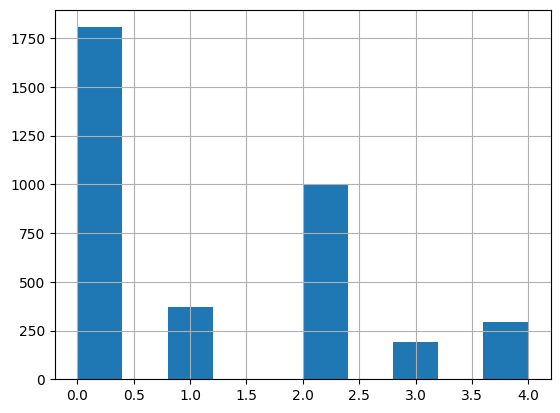

In [ ]:
train_raw_data = pd.read_csv('/content/drive/MyDrive/cfPublicData/aptos/train.csv')
train_raw_data["filename"] = train_raw_data["id_code"].map(lambda x:os.path.join('/content/drive/MyDrive/cfPublicData/aptos/train_images',x+".png"))
train_raw_data.diagnosis.hist() # See the distribution of the classes
# train_raw_data.dtypes

# # train_data["diagnosis"] = train_data["diagnosis"].astype(str)
# # print(train_data.head())
# # print(train_data.diagnosis.unique()) # Look at different types of classes
# # labels = list(map(str,range(5)))
# # print(labels)

In [ ]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

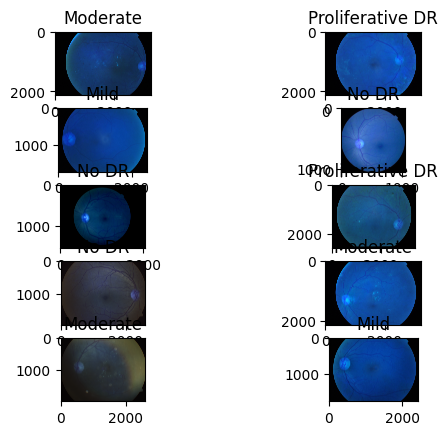

In [ ]:
# Display some images
figure, ax = plt.subplots(5,2)
ax = ax.flatten()
for i,row in train_raw_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join('/content/drive/MyDrive/cfPublicData/aptos/train_images',row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

In [ ]:
train_df,val_df = train_test_split(train_raw_data,random_state=42,shuffle=True,test_size=0.333)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

In [ ]:
X_train,Y_train = load_raw_images_df(train_df,"filename","diagnosis",img_size,5)
X_val,Y_val = load_raw_images_df(val_df,"filename","diagnosis",img_size,5)


In [ ]:
unique, counts = np.unique(Y_train, return_counts=True)

# Create a dictionary of unique values and counts
unique_counts = dict(zip(unique, counts))

print(unique_counts)

In [ ]:
Y_train_labels = np.argmax(Y_train,axis=1)


In [ ]:
unique_classes = np.unique(Y_train_labels)
class_counts = np.bincount(Y_train_labels)

# Calculate class weights manually
total_samples = len(Y_train_labels)
class_weights = {cls: total_samples / (len(unique_classes) * count)
                 for cls, count in zip(unique_classes, class_counts)}
cls_wt_dict = dict(enumerate(class_weights))
print(class_weights)
#print(cls_wt_dict)

{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [ ]:
datagen = ImageDataGenerator(

            zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=batch_size, alpha=0.2, datagen=datagen)()

In [ ]:
def buildModel():
    DenseNet121_model = DenseNet121(include_top=False,weights=None,input_tensor=keras.layers.Input(shape=(img_size,img_size,3)))
    DenseNet121_model.load_weights('/content/drive/MyDrive/cfPublicData/aptos/input/DenseNet-BC-121-32-no-top.h5')
#     model = keras.Sequential()

#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu',
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))

    p  = keras.layers.GlobalAveragePooling2D()(DenseNet121_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d11 = keras.layers.Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = keras.layers.Dense(units = 5, activation = 'softmax')(d11)
    model = keras.models.Model(inputs = DenseNet121_model.input,outputs = o1)
    # Initial learning rate
    initial_learning_rate = 0.01

    # Define the decay strategy
    lr_schedule = ExponentialDecay(
      initial_learning_rate=initial_learning_rate,
      decay_steps=100000,  # This is an example value; adjust to your dataset size and batch size
      decay_rate=0.96,     # This is an example value; adjust according to how you want the learning rate to decay
      staircase=True
    )
    #sgd = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    sgd = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
mymodel = buildModel()

In [ ]:
EPOCHS = 10
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/cfPublicData/aptos/working/DenseNet121.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [ ]:
print(qwk)

In [ ]:
X_train.shape

(2442, 224, 224, 3)

In [ ]:
# Warm up the model with class weights
EPOCHS = 10
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks,
                         class_weight=class_weights)

<ipython-input-54-aab7b4faa4b9>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,


Epoch 1/10



Epoch 1: val_loss improved from inf to 1.41289, saving model to /content/drive/MyDrive/cfPublicData/aptos/working/DenseNet121.h5
